# Optymalizacja wag w sieci MLP z użyciem algorytmu genetycznego

Zaimplementować proste uczenie MLP z użyciem algorytmu genetycznego. Na wejściu jest: struktura sieci neuronowej i dane uczące. Optymalizowana funkcja to funkcja przekształcająca wektor wag sieci na błąd na zbiorze uczącym. Zastosować standardowe operatory krzyżowania i mutacji.

Przeprowadzić uczenie na zbiorach:

- iris https://archive.ics.uci.edu/ml/datasets/Iris
- multimodal-large (z części laboratorium o sieciach neuronowych)
- auto-mpg (przewidzieć wartość mpg) - http://archive.ics.uci.edu/ml/datasets/Auto+MPG

In [1]:
import numpy as np
import random
import math
import copy

In [2]:
class Layer():
    def __init__(self) -> None:
        self.neurons = []
    
    def __init__(self, num_in: int, num_out: int, weights: list, biases: list) -> None:
        self.num_in = num_in
        self.num_out = num_out
        self.weights = np.array(weights).reshape(num_in, num_out)
        self.biases = np.array(biases).reshape(1, num_out)
        self.rmsprop_w = 0
        self.rmsprop_b = 0
        self.momentum_w = 0
        self.momentum_b = 0
        
    def evaluate(self, input: list) -> list:
        self.input = np.array(input)
        self.z_values = self.input @ self.weights + self.biases
        self.activations = self.activate(self.z_values)
        return self.activations
    
    def __repr__(self) -> str:
        return "Layer(" + str(self.neurons) + ")"
    
    def activate(self, x):
        pass
    
    def gradient(self, x):
        pass
    

class LinearLayer(Layer):
    def activate(self, x):
        return x
    
    def gradient(self, x):
        return np.ones(x.shape)
    
class SigmoidLayer(Layer):
    def activate(self, x):
        return np.exp(x) / (1 + np.exp(x))
    
    def gradient(self, x):
        return self.activate(x) * (1 - self.activate(x))

class TanhLayer(Layer):
    def activate(self, x):
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
    
    def gradient(self, x):
        return 1.0 - self.activate(x)**2

class ReluLayer(Layer):
    def activate(self, x):
        return np.maximum(x, 0)
    
    def gradient(self, x):
        return np.where(x > 0, 1, 0)

class SoftmaxLayer(Layer):
    def activate(self, x):
        e_x = np.exp(x.T - np.max(x, axis=1).T).T
        return (e_x.T / e_x.sum(axis=1).T).T
    
from sklearn.metrics import *
from graphviz import Digraph
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import copy

class Network:
    def __init__(self) -> None:
        self.layers = []
        self.size = []
        self.s = None
    
    def __repr__(self) -> str:
        return "Network(" + "\n\t".join([str(layer) for layer in self.layers]) + ")"
    
    def __init__(self, layer_types: list, size: list, weights=None,biases=None, gen_type="0|1", norm=True, cat=False) -> None:
        assert len(layer_types) == len(size) - 1, "Invalid matrix dimension"
        self.layers = []
        self.size = size
        self.norm = norm
        self.cat = cat
        for i, layer_type in enumerate(layer_types):
            if layer_type == "sigmoid":
                self.addLayerBack(SigmoidLayer(
                    size[i],
                    size[i + 1],
                    weights[i] if weights else Network.generate(gen_type, (size[i], size[i+1])),
                    biases[i] if biases else Network.generate(gen_type, (size[i+1], 1))))
            elif layer_type == "linear":
                self.addLayerBack(LinearLayer(
                    size[i],
                    size[i + 1],
                    weights[i] if weights else Network.generate(gen_type, (size[i], size[i+1])),
                    biases[i] if biases else Network.generate(gen_type, (size[i+1], 1))))
            elif layer_type == "relu":
                self.addLayerBack(ReluLayer(
                    size[i],
                    size[i + 1],
                    weights[i] if weights else Network.generate(gen_type, (size[i], size[i+1])),
                    biases[i] if biases else Network.generate(gen_type, (size[i+1], 1))))
            elif layer_type == "tanh":
                self.addLayerBack(TanhLayer(
                    size[i],
                    size[i + 1],
                    weights[i] if weights else Network.generate(gen_type, (size[i], size[i+1])),
                    biases[i] if biases else Network.generate(gen_type, (size[i+1], 1))))
            elif layer_type == "softmax":
                self.addLayerBack(SoftmaxLayer(
                    size[i],
                    size[i + 1],
                    weights[i] if weights else Network.generate(gen_type, (size[i], size[i+1])),
                    biases[i] if biases else Network.generate(gen_type, (size[i+1], 1))))
            else:
                logging.error("Invalid layer type")
    
    @staticmethod
    def substr(a, b):
        return [a[i] - b[i] for i in range(len(a))]
    
    @staticmethod
    def generate(gen_type: str, n: tuple) -> np.array:
        if gen_type == "0|1":
            return np.random.uniform(0, 1, n)
        elif gen_type == "-1|1":
            return np.random.uniform(-1, 1, n)
        elif gen_type == "norm":
            return np.random.normal(0, 1, n)
        elif gen_type == "zero":
            return np.zeros(n)
        
    
    def addLayerBack(self, layer: Layer) -> None:
        self.layers.append(layer)
    
    def forward(self, x: list) -> list:
        input = x
        for layer in self.layers:
            input = layer.evaluate(input)
        return input
    
    def predict(self, x):
        out = self.forward(x)
        if self.norm:
            out = self.s.inverse_transform(out)
        if self.cat:
            return [np.argmax(o) for o in out]
        return out
        

# tests
network = Network(["linear"], [2, 1], [[[2,3]]], [[1]])
assert network.forward([[2,3]]) == [[14]]

network2 = Network(["linear"], [1, 2], [
        [[2], [3]]
], [[[1], [2]]])
assert np.array_equal(network2.forward([[5]]), [[11, 17]])

In [36]:
class GenAlg:
    def __init__(self, network, n_var, n_population=1000, rand_min=-10, rand_max=10):
        self.network = network
        self.n_var = n_var
        self.n_population = n_population
        self.population = np.random.uniform(rand_min, rand_max, size=(n_population, n_var))
        
    def iterate(self, n_iterations=100):
        scores = []
        for i in range(n_iterations):
            mutated = self.mutation()
            children = self.crossover()
            current_population = np.concatenate((self.population, mutated, children))
            evaluated = [self.network.get_score(pop) for pop in current_population]
            new_population = self.selection(current_population, evaluated)
            self.population = new_population
            scores.append(self.get_min_score())
        return scores
    
    def mutation(self):
        p = np.random.permutation(self.n_population)
        mutated_size = math.floor(self.n_population*0.2)
        return self.population[p][0:mutated_size] + np.random.normal(0, 1, size=(mutated_size, self.n_var))
    
    def crossover(self):
        p = np.random.permutation(self.n_population)
        parents_size = math.floor(self.n_population*0.7)
        parents = self.population[p][0:parents_size]
        children = np.array([self.cross(parents[i], parents[i+1]) for i in range(0, parents_size-1, 2)])
        return children.reshape(len(children) * 2, self.n_var)
        
    @staticmethod
    def cross(parent1, parent2):
        i = random.randint(0, len(parent1)-1)
        child1 = np.concatenate((parent1[0:i],parent2[i:]))
        child2 = np.concatenate((parent2[0:i],parent1[i:]))
        return [child1, child2]
    
    def evaluate(self, population):
        outputs = list(map(self.network.get_score, population))
        population_min = min(outputs)
        return outputs - population_min + 0.01
    
    def selection(self, population, values):
        new_population = copy.deepcopy(population)
        to_remove = len(population) - self.n_population
        for i in range(to_remove):
            idx = random.choices(range(len(values)), weights=values, k=1)
            new_population = np.delete(new_population, idx, axis=0)
            values = np.delete(values, idx)
        return new_population
    
    def get_min(self):
        evaluated = self.evaluate(self.population)
        return self.population[evaluated == min(evaluated)][0]
    
    def get_min_score(self):
        return self.network.get_score(self.get_min())
        

In [67]:
def vector_to_weights(vector_,layers):
    n = len(layers) - 1
    matrices_ = [layers[i]*layers[i+1] for i in range(len(layers)-1)] + [layers[i+1] for i in range(n)]
    matrices_.insert(0,0)
    matrices_cs = np.cumsum(matrices_)
    weights = [vector_[matrices_cs[i]:matrices_cs[i+1]].reshape(layers[i], layers[i+1]) for i in range(n)]
    biases = [vector_[matrices_cs[n+i]:matrices_cs[n+i+1]].reshape(layers[i+1], 1) for i in range(n)]
    return (weights, biases)

class NetworkWrapper:
    def __init__(self, layer_types: list, size: list, score_fun, X, y, cat=False):
        self.layer_types = layer_types
        self.size = size
        self.cat = cat
        self.score_fun = score_fun
        self.X = X
        self.y = y
        
    def get_score(self, weights):
        w, b = vector_to_weights(weights, self.size)
        mlp = Network(self.layer_types, self.size, cat=self.cat, weights=w, biases=b, norm=False)
        y_ = mlp.predict(self.X)
        return self.score_fun(self.y, y_)

## iris

In [38]:
from sklearn import datasets
df = datasets.load_iris()['data']
labels = datasets.load_iris()['target']

In [39]:
from sklearn.metrics import accuracy_score

def reversed_accuracy(x,y):
    return 1.0-accuracy_score(x,y)
    
wrapper = NetworkWrapper(["sigmoid", "sigmoid", "softmax"], [4,10,10,3], reversed_accuracy, df, labels, cat=True)

gen = GenAlg(wrapper, 4*10+10*10+10*3+23)
scores = gen.iterate(30)

Text(0, 0.5, '1-acc')

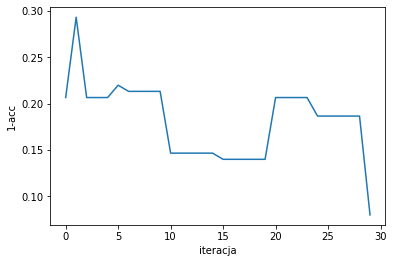

In [40]:
import matplotlib.pyplot as plt
plt.plot(range(len(scores)), scores)
plt.xlabel("iteracja")
plt.ylabel("1-acc")

In [41]:
print("Accuracy:", 1.0-scores[-1])

Accuracy: 0.92


## multimodal-large

In [149]:
import pandas as pd
df = pd.read_csv('mio3/multimodal-large-test.csv')

In [150]:
x = np.asarray((df['x']-df['x'].mean())/df['x'].std()).reshape(-1, 1)
y = np.asarray((df['y']-df['y'].mean())/df['y'].std()).reshape(-1, 1)

In [151]:
from sklearn.metrics import mean_absolute_error
np.random.seed(2137)

wrapper = NetworkWrapper(["sigmoid", "linear"], [1,10,1], mean_absolute_error, x, y, cat=False)

gen = GenAlg(wrapper, 1*10+10*1+11)
scores = gen.iterate(30)
scores = [score * df['y'].std() + df['y'].mean() for score in scores]

Text(0, 0.5, 'MAE')

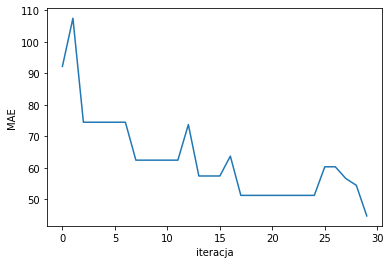

In [152]:
plt.plot(range(len(scores)), scores)
plt.xlabel("iteracja")
plt.ylabel("MAE")

In [153]:
print("MAE:", scores[-1])

MAE: 44.66171331398995


In [154]:
print(df['y'].min())
print(df['y'].max())

-80
160


## auto-mpg

In [118]:
df = pd.read_csv('mio3/auto-mpg.data', sep='\s+', header=None)
df = df[df[3] != "?"]

def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        mean_value = df[feature_name].mean()
        std_value = df[feature_name].std()
        result[feature_name] = (df[feature_name] - mean_value) / std_value
    return result

y = df.loc[:,0].to_numpy()
y_mean = y.mean()
y_std = y.max()
y = (y - y_mean) / y_std

x = df.loc[:,1:7]
x = x.apply(pd.to_numeric)
x = normalize(x)
x = x.to_numpy()

In [146]:
np.random.seed(2137)
wrapper = NetworkWrapper(["sigmoid", "sigmoid", "linear"], [7, 10, 10, 1], mean_absolute_error, x, y, cat=False)

gen = GenAlg(wrapper, 7*10+10*10+10*1+21, 300, rand_min=-5, rand_max=5)
scores = gen.iterate(100)
scores = [score * y_std+y_mean for score in scores]

Text(0, 0.5, 'MAE')

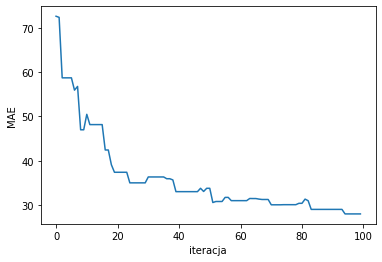

In [147]:
plt.plot(range(len(scores)), scores)
plt.xlabel("iteracja")
plt.ylabel("MAE")

### iris
Algorytm genetyczny poradził sobie całkiem dobrze. Accuracy 92% jest zazwyczaj satysfakcjonujące.

### multimodal large
Tutaj wynik już jest trochę gorszy. MAE trochę straszy, ale w kontekście zakresu y nie wygląda aż tak źle. Prawdopodobnie wystarczy zwiększyć liczbę iteracji.

### auto-mpg
Choć wykres MAE wygląda ok, to wynik już nie za bardzo. y osiąga wartości od 9 do 46, więc błąd na poziomie 30 to bardzo dużo. Kilka razy udało mi się osiągnąć wyniki rzędu 15, ale dalej są raczej mało satysfakcjonujące. Pewnie trzeba by popracować nad zmianą architektury sieci.